In [1]:
import ciw
import matplotlib.pyplot as plt
import numpy as np

import ambulance_game as abg

# Single server Queue (M|M|1)

![single](Bin/single-server-queue.PNG)

In [2]:
arrival_rate = 2
service_rate = 2.5
num_of_servers = 1

In [3]:
model = ciw.create_network(
    arrival_distributions=[ciw.dists.Exponential(arrival_rate)],
    service_distributions=[ciw.dists.Exponential(service_rate)],
    number_of_servers=[num_of_servers],
)
model

In [4]:
ciw.seed(0)
Q_1 = ciw.Simulation(model)
Q_1.simulate_until_max_time(1000)

In [5]:
Q_1.nodes[-1].all_individuals[10].data_records

[Record(id_number=11, customer_class=0, node=1, arrival_date=5.905868416408085, waiting_time=1.3406883875651285, service_start_date=7.246556803973213, service_time=0.2555717304920053, service_end_date=7.502128534465219, time_blocked=0.0, exit_date=7.502128534465219, destination=-1, queue_size_at_arrival=2, queue_size_at_departure=4)]

In [6]:
ind = Q_1.nodes[-1].all_individuals[10]
print(ind)
print("Arrival date : ", round(ind.data_records[0].arrival_date, 2))
print("Waiting time : ", round(ind.data_records[0].waiting_time, 2))
print("Service time : ", round(ind.data_records[0].service_time, 2))
print("Exit date : ", round(ind.data_records[0].exit_date, 2))

Individual 11
Arrival date :  5.91
Waiting time :  1.34
Service time :  0.26
Exit date :  7.5


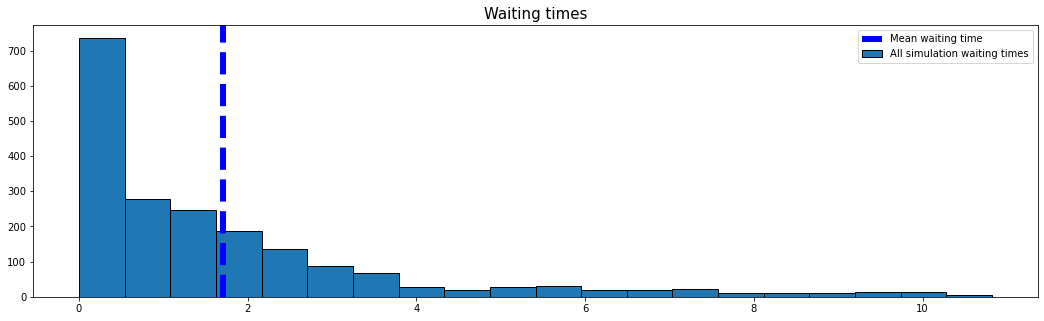

In [23]:
all_waits_1 = tuple(
    ind.data_records[0].waiting_time 
    for ind in Q_1.nodes[-1].all_individuals
)
plt.figure(figsize=(18,5))
plt.hist(all_waits_1, ec="black", bins=20)
plt.axvline(np.mean(all_waits_1), color="blue", linestyle="dashed", linewidth=6)
plt.legend(["Mean waiting time", "All simulation waiting times"])
plt.title("Waiting times", fontsize=15);

# 3-server queue (M|M|3)

![multiplesss](Bin/multiple-server-queues.PNG)

In [8]:
arrival_rate = 2
service_rate = 0.8
num_of_servers = 3

In [9]:
model = ciw.create_network(
    arrival_distributions=[ciw.dists.Exponential(arrival_rate)],
    service_distributions=[ciw.dists.Exponential(service_rate)],
    number_of_servers=[num_of_servers],
)
ciw.seed(0)
Q_2 = ciw.Simulation(model)
Q_2.simulate_until_max_time(1000)

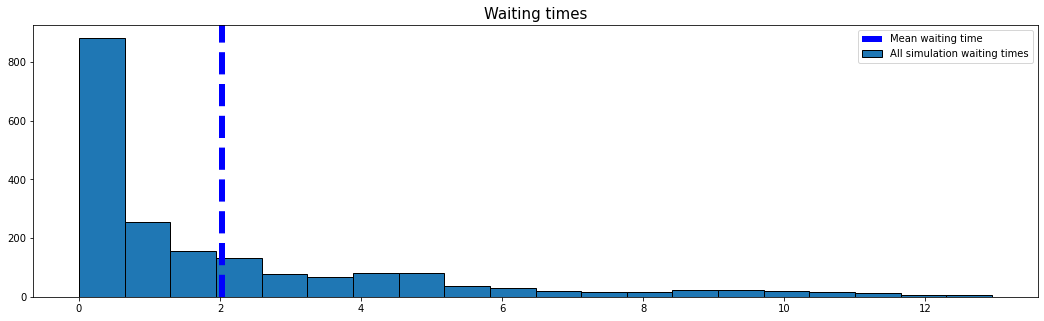

In [22]:
all_waits_2 = tuple(
    ind.data_records[0].waiting_time 
    for ind in Q_2.nodes[-1].all_individuals
)
plt.figure(figsize=(18,5))
plt.hist(all_waits_2, ec="black", bins=20)
plt.axvline(np.mean(all_waits_2), color="blue", linestyle="dashed", linewidth=6)
plt.legend(["Mean waiting time", "All simulation waiting times"])
plt.title("Waiting times", fontsize=15);

# Multiple runs

In [11]:
mean_waits = tuple()
for seed in range(10):
    ciw.seed(seed)
    Q = ciw.Simulation(model)
    Q.simulate_until_max_time(1000)
    mean_waits += (np.mean([ind.data_records[0].waiting_time for ind in Q.nodes[-1].all_individuals]),)

In [12]:
print("Mean waiting time from multiple runs of simulation: ", np.mean(mean_waits))

Mean waiting time from multiple runs of simulation:  1.5981216857675942


# Custom systme of queues

![custom](Bin/custom-queue.PNG)

In [13]:
ciw.Node

ciw.node.Node

In [14]:
ciw.Node.finish_service

<function ciw.node.Node.finish_service(self)>

In [15]:
ciw.Node.release_blocked_individual

<function ciw.node.Node.release_blocked_individual(self)>

In [16]:
class CustomNode(ciw.Node):

    def finish_service(self):
        next_individual, next_individual_index = self.find_next_individual()
        self.change_customer_class(next_individual)
        next_node = self.next_node(next_individual)
        next_individual.destination = next_node.id_number
        if not np.isinf(self.c):
            next_individual.server.next_end_service_date = float("Inf")
        
        blockage = self.id_number == 1 and next_node.number_of_individuals >= threshold

        if (
            next_node.number_of_individuals < next_node.node_capacity
        ) and not blockage:
            self.release(next_individual_index, next_node)
        else:
            self.block_individual(next_individual, next_node)


    def release_blocked_individual(self):

        continue_blockage = self.id_number == 2 and self.number_of_individuals >= threshold 

        if (
            self.len_blocked_queue > 0
            and self.number_of_individuals < self.node_capacity
            and not continue_blockage
        ):
            node_to_receive_from = self.simulation.nodes[self.blocked_queue[0][0]]
            individual_to_receive_index = [
                ind.id_number for ind in node_to_receive_from.all_individuals
            ].index(self.blocked_queue[0][1])
            individual_to_receive = node_to_receive_from.all_individuals[
                individual_to_receive_index
            ]
            self.blocked_queue.pop(0)
            self.len_blocked_queue -= 1
            if individual_to_receive.interrupted:
                individual_to_receive.interrupted = False
                node_to_receive_from.interrupted_individuals.remove(
                    individual_to_receive
                )
                node_to_receive_from.number_interrupted_individuals -= 1
            node_to_receive_from.release(individual_to_receive_index, self)

In [17]:
lambda_2 = 2
lambda_1 = 3
mu = 2
num_of_servers = 3
threshold = 10
system_capacity = float("inf")
buffer_capacity = float("inf")

In [18]:
model = ciw.create_network(
    arrival_distributions=[
        ciw.dists.Exponential(lambda_2),
        ciw.dists.Exponential(lambda_1),
    ],
    service_distributions=[
        ciw.dists.Deterministic(0), 
        ciw.dists.Exponential(mu)],
    routing=[
        [0.0, 1.0], 
        [0.0, 0.0]
    ],
    number_of_servers=[
        buffer_capacity, num_of_servers
    ],
    queue_capacities=[
        0, float("inf")
    ],
)
ciw.seed(0)
Q_3 = ciw.Simulation(model, node_class=CustomNode, tracker=ciw.trackers.NodePopulation())
Q_3.simulate_until_max_time(1000)

In [19]:
ind = Q_3.nodes[-1].all_individuals[10]
print(ind)
print("Arrival date : ", ind.data_records[-1].arrival_date)
print("Waiting time : ", ind.data_records[-1].waiting_time)
print("Service time : ", ind.data_records[-1].service_time)
print("Exit date : ", ind.data_records[-1].exit_date)

Individual 12
Arrival date :  3.136534248470756
Waiting time :  0.14960784498256974
Service time :  0.4719427104336873
Exit date :  3.758084803887013


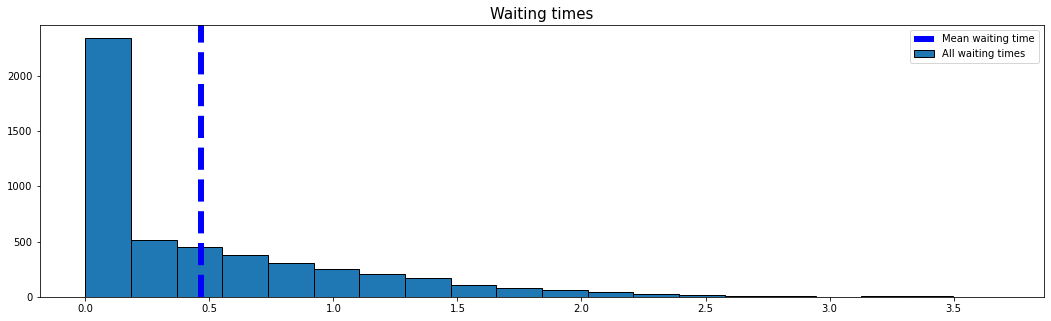

In [21]:
all_waits_3 = tuple(
    ind.data_records[-1].waiting_time 
    for ind in Q_3.nodes[-1].all_individuals
)
plt.figure(figsize=(18,5))
plt.hist(all_waits_3, ec="black", bins=20)
plt.axvline(np.mean(all_waits_3), color="blue", linestyle="dashed", linewidth=6)
plt.legend(["Mean waiting time", "All waiting times"])
plt.title("Waiting times", fontsize=15);

# Analytical approach

## - Single-server queue (M|M|1)

$$
    W_q = \frac{\lambda}{\mu ( \mu - \lambda )}
$$

In [24]:
def get_waiting_time_1_server(λ, μ):
    W_q = λ / (μ * (μ - λ))
    return W_q

In [31]:
arrival_rate = 2
service_rate = 2.5
num_of_servers = 1

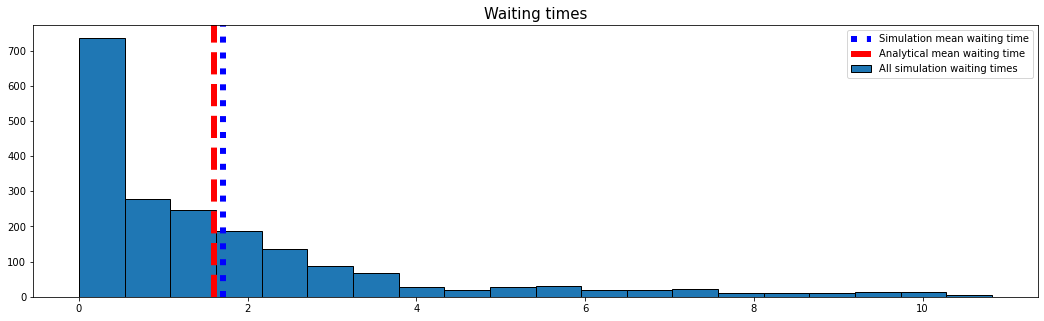

In [32]:
plt.figure(figsize=(18,5))
plt.hist(all_waits_1, ec="black", bins=20)
plt.axvline(np.mean(all_waits_1), color="blue", linestyle="dotted", linewidth=6)
plt.axvline(get_waiting_time_1_server(arrival_rate, service_rate), color="red", linestyle="dashed", linewidth=6)
plt.legend(["Simulation mean waiting time", "Analytical mean waiting time", "All simulation waiting times"])
plt.title("Waiting times", fontsize=15);

## - Multiple-server queue (M|M|C)

$$
    W_q = \frac{1}{C \mu} \frac{(C \rho) ^ C}{C! (1 - \rho ^ 2)} P_0, \hspace{1cm} \text{where } \rho = \frac{\lambda}{C \mu}
$$

In [33]:
def get_waiting_time_multiple_servers(λ, μ, c):
    P_0_inv = sum((λ / μ) ** n / np.math.factorial(n) for n in range(c))
    P_0_inv += (λ / μ) ** c / (np.math.factorial(c) * (1 - (λ / (c * μ))))
    P_0 = 1 / P_0_inv
    
    W_q = (λ / μ) ** c / ((c * μ) * np.math.factorial(c) * (1 - λ / (c * μ)) ** 2)
    W_q *= P_0
    return W_q

In [34]:
arrival_rate = 2
service_rate = 0.8
num_of_servers = 3

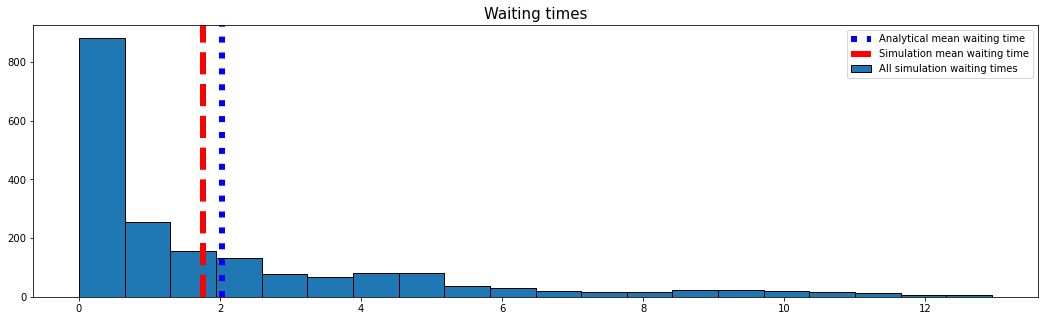

In [37]:
plt.figure(figsize=(18,5))
plt.hist(all_waits_2, ec="black", bins=20)
plt.axvline(np.mean(all_waits_2), color="blue", linestyle="dotted", linewidth=6)
plt.axvline(get_waiting_time_multiple_servers(arrival_rate, service_rate, num_of_servers), color="red", linestyle="dashed", linewidth=6)
plt.legend(["Analytical mean waiting time", "Simulation mean waiting time", "All simulation waiting times"])
plt.title("Waiting times", fontsize=15);

## - Custom queue
$$
    W_q = 
        \frac{\lambda_1 P_{L'_1}}{\lambda_2 P_{L'_2} + \lambda_1 P_{L'_1}} 
        \frac{\sum_{(u,v) \in S_A^1} w_1(u,v) \pi_{(u,v)}}{\sum_{(u,v) \in S_A^1} \pi_{(u,v)}}
        + \frac{\lambda_2 P_{L'_2}}{\lambda_2 P_{L'_2} + \lambda_1 P_{L'_1}}
        \frac{\sum_{(u,v) \in S_A^2} w_2(u,v) \pi_{(u,v)}}{\sum_{(u,v) \in S_A^2} \pi_{(u,v)}}
$$

In [38]:
import ambulance_game as abg

In [39]:
params = {
    "lambda_1" : 1,
    "lambda_2" : 3,
    "mu" : 2,
    "num_of_servers" : 2,
    "threshold" : 6,
    "system_capacity" : 6,
    "buffer_capacity" : 4,
}

In [40]:
analytical_mean_wait = abg.markov.get_mean_waiting_time_using_markov_state_probabilities(**params)
analytical_mean_wait

0.6026901189860321

In [47]:
results = abg.simulation.get_multiple_runs_results(**params, seed_num=0)
simulation_waits = [w.waiting_times for w in results]
simulation_waits = sum(simulation_waits, [])

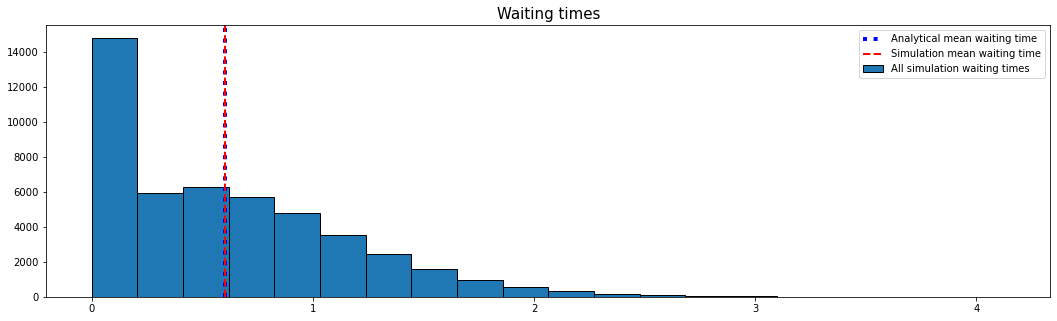

In [48]:
plt.figure(figsize=(18,5))
plt.hist(simulation_waits, ec="black", bins=20);
plt.axvline(np.mean(simulation_waits), color="blue", linestyle="dotted", linewidth=4)
plt.axvline(analytical_mean_wait, color="red", linestyle="dashed", linewidth=2)
plt.legend(["Analytical mean waiting time", "Simulation mean waiting time", "All simulation waiting times"])
plt.title("Waiting times", fontsize=15);

# Appendix

In [ ]:
def release_blocked_individual(self):
    """
    Releases an individual who becomes unblocked when
    another individual is released:
        - check if anyone is blocked by this node
        - find the individual who has been blocked the longest
        - remove that individual from blocked queue
        - check if that individual had their service interrupted
        - release that individual from their node
    """

    continue_blockage = (
        self.number_of_individuals >= threshold and self.id_number == 2
    )

    if None and not continue_blockage:
        pass

In [ ]:
def finish_service(self):
    """
    The next individual finishes service:
        - finds the individual to finish service
        - check if they need to change class
        - find their next node
        - release the individual if there is capacity at destination,
        otherwise cause blockage
    """

    blockage = (
        next_node.number_of_individuals >= threshold and self.id_number == 1
    )

    if None and not blockage:
        pass

In [ ]:
state_probabilities_dictionary = (
    Q.statetracker.state_probabilities()
)
np.sum([i for i in state_probabilities_dictionary.values()])